# PageRank analysis 
This notebook is a 

In [101]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ipywidgets import interact, FloatSlider
import networkx as nx
from matplotlib.animation import FuncAnimation

A = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
], dtype=float)

n = A.shape[0]
S = np.ones((n, n)) / n


def pagerank_power_method_classic(m, max_iter=1000, tol=1e-10):
    M = (1 - m) * A + m * S
    v = np.ones(n)
    v /= np.linalg.norm(v, 2)
    lam_old = np.inf
    
    for _ in range(max_iter):
        w = M @ v
        lam = v @ w
        v = w / np.linalg.norm(w, 2)
        if abs(lam - lam_old) < tol * max(abs(lam), 1e-12):
            break

        lam_old = lam
    v = v / v.sum()

    return v


def plot_pagerank_classic(m):
    v = pagerank_power_method_classic(m)

    plt.figure(figsize=(7, 4))
    plt.bar(range(1, n+1), v)
    plt.ylim(0, 0.5)
    plt.xlabel('Pagina')
    plt.ylabel('Rank')
    plt.title(f'Classic Power Method – PageRank (m = {m:.2f})')

    for i, val in enumerate(v):
        plt.text(i+1, val + 0.01, f"{val:.3f}", ha='center')

    plt.show()


interact(
    plot_pagerank_classic,
    m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m')
);

interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

A = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
], dtype=float)

n = A.shape[0]
S = np.ones((n, n)) / n


def pagerank_power_method_info(m, max_iter=1000, tol=1e-10):
    M = (1 - m) * A + m * S

    v = np.ones(n)
    v /= np.linalg.norm(v, 2)

    lam_old = None
    lambdas = []
    errors = []

    for _ in range(max_iter):
        w = M @ v

        lam = v @ w       # Rayleigh quotient (v ha norma 1)
        lambdas.append(lam)
        v = w / np.linalg.norm(w, 2)
        if lam_old is None:
            errors.append(np.nan)
        else:
            errors.append(abs(lam - lam_old))

        if lam_old is not None and abs(lam - lam_old) < tol * max(abs(lam), 1e-12):
            break

        lam_old = lam
        

    return np.array(lambdas), np.array(errors)


def plot_rayleigh_and_error(m):
    lambdas, errors = pagerank_power_method_info(m)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot 1: evoluzione di Rayleigh
    ax[0].plot(lambdas, marker='o')
    ax[0].set_title("Rayleigh Quotient Evolution")
    ax[0].set_xlabel("Iteration")

    # Plot 2: errore in scala logaritmica (ignoriamo la prima entry NaN)
    mask = np.isfinite(errors)
    ax[1].plot(np.where(mask)[0], errors[mask], marker='o')
    ax[1].set_yscale("log")
    ax[1].set_title("|λ(m+1) − λ(m)| (log scale)")
    ax[1].set_xlabel("Iteration")

    plt.tight_layout()
    plt.show()


interact(
    plot_rayleigh_and_error,
    m=FloatSlider(value=0.15, min=0.0, max=1.0, step=0.01, description='m')
);


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, step=0.01), Output()), _dom_classes=('…

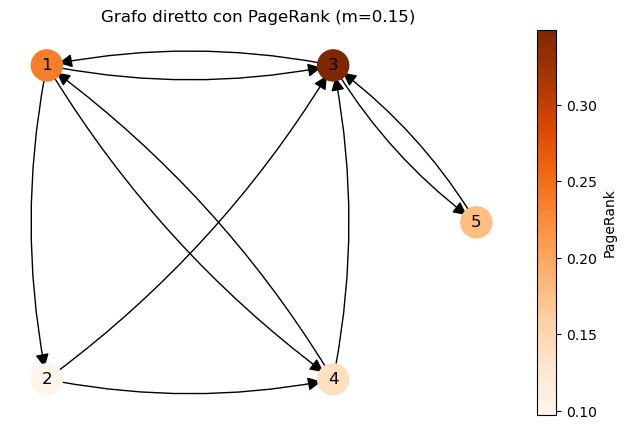

In [95]:
# Matrice di adiacenza
A = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
])

n = A.shape[0]

# Calcolo PageRank con eig
m = 0.15
S = np.ones((n,n))/n
M = (1-m)*A + m*S
autovalori, autovettori = np.linalg.eig(M)
idx = np.argmin(np.abs(autovalori - 1))
v = autovettori[:, idx].real
if np.sum(v) < 0:
    v = -v
v = v / np.sum(v)

# Creazione grafo diretto
G = nx.DiGraph()
G.add_nodes_from(range(1,n+1))

for i in range(n):
    for j in range(n):
        if A[i,j] > 0:
            G.add_edge(j+1, i+1)

# Posizioni manuali: quadrato + nodo 5 fuori
pos = {
    1: (0, 1),     # alto sx
    3: (1, 1),     # alto dx
    2: (0, 0),     # basso sx
    4: (1, 0),     # basso dx
    5: (1.5, 0.5)  # centro fuori a destra
}

# Normalizza PageRank per color mapping
norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  # colormap

# --- Disegno grafo con figure e axes espliciti ---
fig, ax = plt.subplots(figsize=(8,5))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],
                           connectionstyle='arc3,rad=0.1',
                           arrowstyle='-|>', arrowsize=20,
                           ax=ax)

# Colorbar corretta
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'Grafo diretto con PageRank (m={m})')
ax.axis('off')
plt.show()

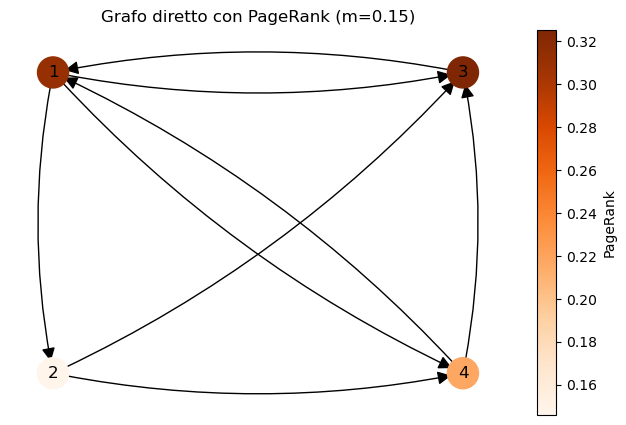

In [97]:
# Matrice di adiacenza
A = np.array([
    [0,   0,   1/2, 1/2],
    [1/3, 0,   0,   0],
    [1/3, 1/2, 0,   1/2],
    [1/3, 1/2, 0,   0]
])

n = A.shape[0]

# Calcolo PageRank con eig
m = 0.15
S = np.ones((n,n))/n
M = (1-m)*A + m*S
autovalori, autovettori = np.linalg.eig(M)
idx = np.argmin(np.abs(autovalori - 1))
v = autovettori[:, idx].real
if np.sum(v) < 0:
    v = -v
v = v / np.sum(v)

# Creazione grafo diretto
G = nx.DiGraph()
G.add_nodes_from(range(1,n+1))

for i in range(n):
    for j in range(n):
        if A[i,j] > 0:
            G.add_edge(j+1, i+1)

# Posizioni manuali: quadrato + nodo 5 fuori
pos = {
    1: (0, 1),     # alto sx
    3: (1, 1),     # alto dx
    2: (0, 0),     # basso sx
    4: (1, 0),     # basso dx
}

# Normalizza PageRank per color mapping
norm = plt.Normalize(v.min(), v.max())
node_colors = plt.cm.Oranges(norm(v))  # colormap

# --- Disegno grafo con figure e axes espliciti ---
fig, ax = plt.subplots(figsize=(8,5))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

for (u,v_) in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v_)],
                           connectionstyle='arc3,rad=0.1',
                           arrowstyle='-|>', arrowsize=20,
                           ax=ax)

# Colorbar corretta
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=norm)
sm.set_array(v)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('PageRank')

ax.set_title(f'Grafo diretto con PageRank (m={m})')
ax.axis('off')
plt.show()

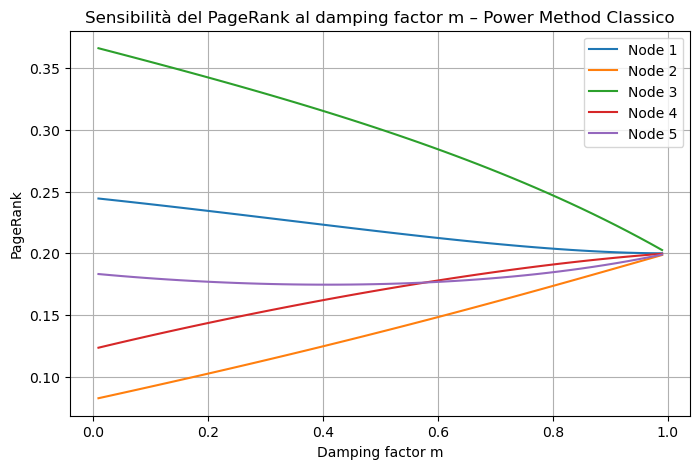

In [98]:
# Matrice di adiacenza (già stocastica a colonne)
A = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
], dtype=float)

n = A.shape[0]


# -------------------------------------------------------
# POWER METHOD CLASSICO (L2-normalizzato)
# -------------------------------------------------------
def pagerank_power_method_classic(A, m=0.15, tol=1e-10, max_iter=1000):
    n = A.shape[0]
    S = np.ones((n, n)) / n
    M = (1 - m) * A + m * S

    v = np.ones(n)
    v = v / np.linalg.norm(v, 2)

    history = [v.copy()]

    lam_old = None
    lambdas = []
    errors = []

    for _ in range(max_iter):
        w = M @ v

        # Rayleigh quotient classico
        lam = (v @ (M @ v)) / (v @ v)
        lambdas.append(lam)

        # errore tra iterazioni
        if lam_old is None:
            errors.append(np.nan)
        else:
            errors.append(abs(lam - lam_old))

        # normalizzazione L2
        v = w / np.linalg.norm(w, 2)

        history.append(v.copy())

        # criterio di stop
        if lam_old is not None and abs(lam - lam_old) < tol * max(abs(lam), 1e-12):
            break

        lam_old = lam

    # PageRank finale → normalizzato in L1
    pr = v / v.sum()

    return pr, np.array(history), np.array(lambdas), np.array(errors)

m_values = np.linspace(0.01, 0.99, 50)
pagerank_vs_m = []

for m_val in m_values:
    pr, _, _, _ = pagerank_power_method_classic(A, m=m_val)
    pagerank_vs_m.append(pr)

pagerank_vs_m = np.array(pagerank_vs_m)

plt.figure(figsize=(8, 5))
for i in range(n):
    plt.plot(m_values, pagerank_vs_m[:, i], label=f'Node {i+1}')

plt.xlabel('Damping factor m')
plt.ylabel('PageRank')
plt.title('Sensibilità del PageRank al damping factor m – Power Method Classico')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [39]:
# --- Matrici ---
A5 = np.array([
    [0,   0,   1/2, 1/2, 0],
    [1/3, 0,   0,   0,   0],
    [1/3, 1/2, 0,   1/2, 1],
    [1/3, 1/2, 0,   0,   0],
    [0,   0,   1/2, 0,   0]
])

A4 = np.array([
    [0,   0,   1/2, 1/2],
    [1/3, 0,   0,   0],
    [1/3, 1/2, 0,   1/2],
    [1/3, 1/2, 0,   0]
])

nodes = ['1','2','3','4']

def pagerank_power_method(A, m=0.15, tol=1e-12, max_iter=1000):
    n = A.shape[0]
    S = np.ones((n, n)) / n
    M = (1 - m) * A + m * S

    # vettore iniziale normalizzato L2
    v = np.ones(n)
    v /= np.linalg.norm(v, 2)

    lam_old = None

    for _ in range(max_iter):
        w = M @ v

        # Rayleigh quotient
        lam = (v @ (M @ v)) / (v @ v)

        # nuovo vettore normalizzato L2
        v_new = w / np.linalg.norm(w, 2)

        if lam_old is not None:
            if abs(lam - lam_old) < tol * max(abs(lam), 1e-12):
                break

        v = v_new
        lam_old = lam

    # normalizzazione L1 per PageRank
    v = v / v.sum()

    return v


def plot_pagerank_comparison(m=0.15):
    v5 = pagerank_power_method(A5, m)
    v4 = pagerank_power_method(A4, m)
    
    x = np.arange(len(nodes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x - width/2, v5[:4], width, label='5-page Web')
    ax.bar(x + width/2, v4, width, label='Original web')

    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_ylabel('PageRank')
    ax.set_title(f'Confronto PageRank: con 5 pagine vs senza pagina 5 (m={m:.2f})')

    # ➜ Legenda in alto a destra
    ax.legend(loc='upper right')

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# Slider interattivo per m
interact(plot_pagerank_comparison,
         m=FloatSlider(value=0.15, min=0.01, max=1, step=0.01, description='m'));


interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, min=0.01, step=0.01), Output()), _dom_…

In [100]:
def plot_pagerank_difference_relative(m=0.15):
    # PageRank con 5 pagine
    v5 = pagerank_eig(A5, m)
    # PageRank con 4 pagine
    v4 = pagerank_eig(A4, m)
    
    # Considero solo i nodi 1-4 del grafo a 5 pagine
    v5_trim = v5[:4]
    
    # Differenza relativa (%)
    diff_rel = ((v5_trim - v4) / v4) * 100
    
    x = np.arange(len(nodes))
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x, diff_rel, width=0.3, color='green', alpha=0.8)  # <-- barre più sottili

    ax.set_xticks(x)
    ax.set_xticklabels(nodes, fontsize=12)
    ax.set_title(f'Page 5 impact on PageRank', fontsize=13)
    ax.set_xlabel('Page')
    ax.set_ylabel('Relative Difference (%)')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Slider interattivo
interact(plot_pagerank_difference_relative,
         m=FloatSlider(value=0.15, min=0.01, max=1, step=0.01, description='m'));



interactive(children=(FloatSlider(value=0.15, description='m', max=1.0, min=0.01, step=0.01), Output()), _dom_…